# 11_2_LEARN-DataAnalysisML

<a target="_blank" href="https://colab.research.google.com/github/hiyama341/ConStrain/blob/main/colab_notebooks/11_2_LEARN_DataAnalysisML.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

In [2]:
# cloning the data repo
!git clone https://github.com/hiyama341/ConStrain_on_google_colab.git

fatal: destination path 'ConStrain_on_google_colab' already exists and is not an empty directory.


## 1. Setup H2O AutoML

In [3]:
%%capture 
!pip install h2o

In [4]:
import h2o
from h2o.automl import H2OAutoML

In [5]:
# If this doesnt work - install java. 
# Start the H2O cluster (locally)
h2o.init(ip="localhost")

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_351"; Java(TM) SE Runtime Environment (build 1.8.0_351-b10); Java HotSpot(TM) 64-Bit Server VM (build 25.351-b10, mixed mode)
  Starting server from /Users/lucaslevassor/opt/anaconda3/envs/constrain/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/tmp5g9iz67x
  JVM stdout: /var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/tmp5g9iz67x/h2o_lucaslevassor_started_from_python.out
  JVM stderr: /var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/tmp5g9iz67x/h2o_lucaslevassor_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,08 secs
H2O_cluster_timezone:,Europe/Copenhagen
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,5 months and 4 days !!!
H2O_cluster_name:,H2O_from_python_lucaslevassor_m0hs9r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.556 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [6]:
#h2o.shutdown()

### 1.1 Import our dataframe as h20 object

Train a model based on the target and the df

In [7]:
first_input_for_ml = pd.read_csv('ConStrain_on_google_colab/Data/AutoML/input_for_ml_1st_iteration_all_analytics.csv')
first_input_for_ml 

,Line_name,0,1,2,3,Amt_norm
0,yp49_A01,1,2,5,1,0.972701
1,yp49_C01,1,2,5,9,0.536658
2,yp49_D01,2,4,7,3,0.175896
3,yp49_E01,2,1,5,7,0.345201
4,yp49_F01,3,3,6,1,26.416324
...,...,...,...,...,...,...
162,yp51_C12,8,3,7,2,0.000000
163,yp51_D12,8,2,7,6,0.614962
164,yp51_E12,8,1,6,10,0.466688
165,yp50_F05,6,1,8,2,15.155009


### 1.2 Investigate how the predictions from the previous ML cycle mathced the sampled strains 

In [8]:
# Run ML with new input 
second_input_for_ml = pd.read_csv('ConStrain_on_google_colab/Data/AutoML/input_for_ml_2nd_iteration_all_analytics.csv')
second_input_for_ml = second_input_for_ml[['Line_name', '0','1','2','3','norm_strict_%']]
second_input_for_ml.columns = ['Line_name', '0','1','2','3','Amt_norm']

In [9]:
list_of_promoters = ["CYC1", "ENO2","PCK1","RPL15B", "CCW12", "TPI1","MLS1","URE2"]

promoter_dict = {i+1:list_of_promoters[i]for i in range(len(list_of_promoters))}


g8h_list_of_index = ["Cacu", "Opum","Cro","Vmin","Smus","Rsep","Oeu","Ccal"]
cpr_list_of_index = ["Cro", "Aan","Ara","Clo","Rse","Ahu","Ani","Cac","Oeu","Cpo"]

pg8h_list_of_index = ['CYC1', 'ENO2']
pcpr_list_of_index = ['CCW12', 'TPI1'] 



g8h_genotype = []
cpr_genotype = []
pg8h_genotype = []
pcpr_genotype = []

# adding index of genotypes to individual rows 
for index, row in second_input_for_ml.iterrows():
    # homologs
    g8h_name = g8h_list_of_index[int(row['0']-1)]
    cpr_name = cpr_list_of_index[int(row['3']-1)]
    
    # promoters
    pg8h_name =promoter_dict[row['1']]
    pcpr_name = promoter_dict[row['2']]
    
    
    # save the genotypes
    g8h_genotype.append(g8h_name)
    cpr_genotype.append(cpr_name)
    pg8h_genotype.append(pg8h_name)
    pcpr_genotype.append(pcpr_name)

second_input_for_ml['G8H'] = g8h_genotype
second_input_for_ml['CPR'] = cpr_genotype
second_input_for_ml['pG8H'] = pg8h_genotype
second_input_for_ml['pCPR'] = pcpr_genotype
second_input_for_ml

,Line_name,0,1,2,3,Amt_norm,G8H,CPR,pG8H,pCPR
0,yp53_A01,4,1,5,2,9.058562,Vmin,Aan,CYC1,CCW12
1,yp53_A02,4,1,5,2,28.175952,Vmin,Aan,CYC1,CCW12
2,yp53_A04,4,2,5,2,80.375862,Vmin,Aan,ENO2,CCW12
3,yp53_A06,5,1,5,2,121.767572,Smus,Aan,CYC1,CCW12
4,yp53_A07,5,2,6,2,159.059724,Smus,Aan,ENO2,TPI1
...,...,...,...,...,...,...,...,...,...,...
124,yp54_A04,4,1,6,1,15.322951,Vmin,Cro,CYC1,TPI1
125,yp54_C04,5,2,6,3,94.318358,Smus,Ara,ENO2,TPI1
126,yp54_C09,3,1,6,3,46.469517,Cro,Ara,CYC1,TPI1
127,yp54_D12,5,1,6,6,3.718051,Smus,Ahu,CYC1,TPI1


In [10]:
second_input_for_ml["Names"] = second_input_for_ml[['G8H', 'pG8H','pCPR', 'CPR']].agg('-'.join, axis=1)
second_input_for_ml =second_input_for_ml[['Names', 'Amt_norm', 'Line_name']]
second_input_for_ml

,Names,Amt_norm,Line_name
0,Vmin-CYC1-CCW12-Aan,9.058562,yp53_A01
1,Vmin-CYC1-CCW12-Aan,28.175952,yp53_A02
2,Vmin-ENO2-CCW12-Aan,80.375862,yp53_A04
3,Smus-CYC1-CCW12-Aan,121.767572,yp53_A06
4,Smus-ENO2-TPI1-Aan,159.059724,yp53_A07
...,...,...,...
124,Vmin-CYC1-TPI1-Cro,15.322951,yp54_A04
125,Smus-ENO2-TPI1-Ara,94.318358,yp54_C04
126,Cro-CYC1-TPI1-Ara,46.469517,yp54_C09
127,Smus-CYC1-TPI1-Ahu,3.718051,yp54_D12


In [11]:
first_round_top_producers = pd.read_csv('ConStrain_on_google_colab/Data/AutoML/top20_ML_predicted_after_first_DBTL_1st_analytics.csv')
first_round_top_producers = first_round_top_producers.sort_values(by='Predicted_strict_production', ascending=False)

first_round_top_producers["Names"] = first_round_top_producers[['G8H', 'pG8H','pCPR', 'CPR']].agg('-'.join, axis=1)
first_round_top_producers  = first_round_top_producers[['Names', 'Predicted_strict_production']]
first_round_top_producers['Predicted_strict_production_rank_pct']= first_round_top_producers['Predicted_strict_production'].rank(pct=True)
first_round_top_producers

,Names,Predicted_strict_production,Predicted_strict_production_rank_pct
0,Smus-ENO2-TPI1-Rse,169.288180,1.000000
1,Rsep-ENO2-TPI1-Ara,162.151856,0.999106
2,Smus-ENO2-CCW12-Ara,161.904255,0.998213
3,Smus-CYC1-TPI1-Ara,157.638727,0.997319
4,Smus-ENO2-TPI1-Aan,156.976470,0.996425
...,...,...,...
1114,Rsep-CYC1-TPI1-Ani,-9.125477,0.004468
1115,Ccal-ENO2-TPI1-Cac,-12.768510,0.003575
1116,Rsep-PCK1-CCW12-Ara,-12.901417,0.002681
1117,Ccal-ENO2-CCW12-Cac,-16.241411,0.001787


In [12]:
second_input_for_ml

,Names,Amt_norm,Line_name
0,Vmin-CYC1-CCW12-Aan,9.058562,yp53_A01
1,Vmin-CYC1-CCW12-Aan,28.175952,yp53_A02
2,Vmin-ENO2-CCW12-Aan,80.375862,yp53_A04
3,Smus-CYC1-CCW12-Aan,121.767572,yp53_A06
4,Smus-ENO2-TPI1-Aan,159.059724,yp53_A07
...,...,...,...
124,Vmin-CYC1-TPI1-Cro,15.322951,yp54_A04
125,Smus-ENO2-TPI1-Ara,94.318358,yp54_C04
126,Cro-CYC1-TPI1-Ara,46.469517,yp54_C09
127,Smus-CYC1-TPI1-Ahu,3.718051,yp54_D12


In [13]:
## merging the unsampled library with the second sampling
predicted_vs_sampled = pd.merge(first_round_top_producers, second_input_for_ml, on=['Names'])
predicted_vs_sampled['norm_strict_measured_rank'] = predicted_vs_sampled['Amt_norm'].rank(pct=True)
predicted_vs_sampled['Predicted_strict_production_rank_pct'] = predicted_vs_sampled['Predicted_strict_production'].rank(pct=True)


#new_input_for_ml['NA_bottom'] = new_input_for_ml['Amt_norm'].rank(na_option='bottom')
#new_input_for_ml['pct_rank'] = new_input_for_ml['Amt_norm'].rank(pct=True)
predicted_vs_sampled = predicted_vs_sampled.sort_values(by= 'Amt_norm', ascending = False)


In [14]:
predicted_vs_sampled

,Names,Predicted_strict_production,Predicted_strict_production_rank_pct,Amt_norm,Line_name,norm_strict_measured_rank
0,Smus-ENO2-TPI1-Rse,169.288180,0.995575,169.631396,yp53_D09,1.000000
10,Rsep-ENO2-TPI1-Clo,103.496648,0.907080,159.517718,yp53_C06,0.991150
4,Smus-ENO2-TPI1-Aan,156.976470,0.964602,159.059724,yp53_A07,0.982301
31,Smus-CYC1-CCW12-Clo,57.162466,0.725664,143.483630,yp53_C01,0.973451
32,Cro-ENO2-TPI1-Cro,56.438602,0.712389,138.267757,yp54_B01,0.964602
...,...,...,...,...,...,...
99,Smus-CYC1-TPI1-Ahu,2.649671,0.123894,0.000000,yp54_D10,0.061947
98,Smus-CYC1-TPI1-Ahu,2.649671,0.123894,0.000000,yp54_D09,0.061947
97,Cro-CYC1-CCW12-Ani,2.686140,0.146018,0.000000,yp53_G04,0.061947
96,Cro-CYC1-CCW12-Ani,2.686140,0.146018,0.000000,yp53_G03,0.061947


In [15]:
from constrain.plotting.plotting import correlation_plot

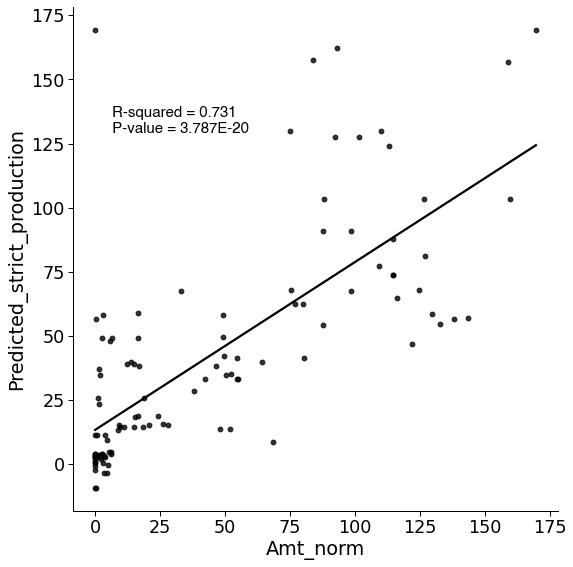

In [16]:
correlation_plot(predicted_vs_sampled,"Amt_norm","Predicted_strict_production")

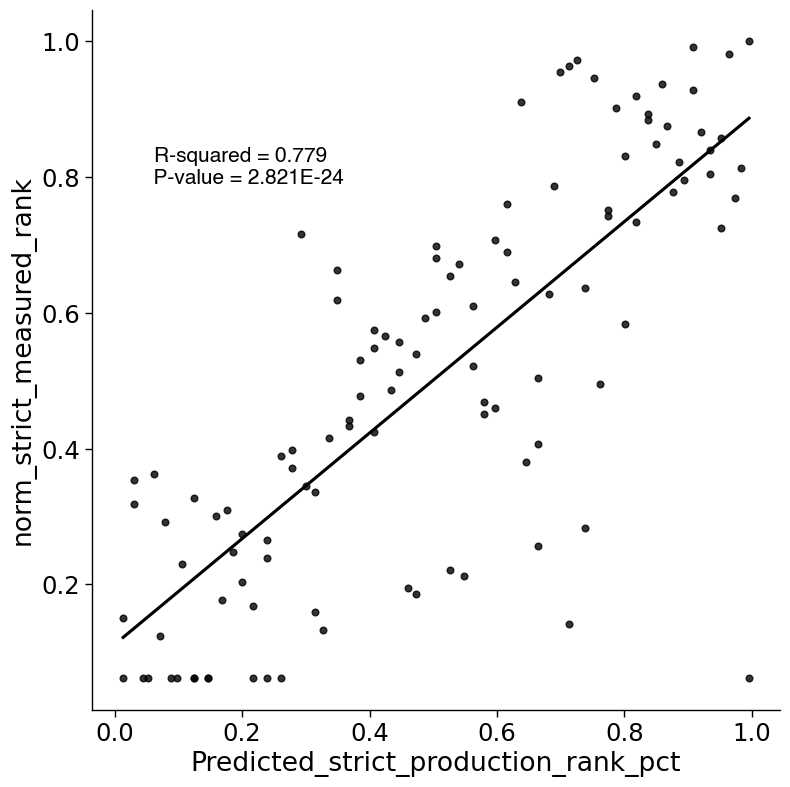

In [17]:
correlation_plot(predicted_vs_sampled,"Predicted_strict_production_rank_pct","norm_strict_measured_rank")

### 1.3 Merging the dataframes for updating the model 

In [27]:
first_input_for_ml = pd.read_csv('ConStrain_on_google_colab/Data/AutoML/input_for_ml_1st_iteration_all_analytics.csv')
second_input_for_ml = pd.read_csv('ConStrain_on_google_colab/Data/AutoML/input_for_ml_2nd_iteration_all_analytics.csv')
second_input_for_ml.columns = ['Line_name', '0','1','2','3','Amt_norm']

In [30]:
new_input_for_ml = pd.concat([first_input_for_ml,second_input_for_ml ])
new_input_for_ml.columns = ['Line_name', '0','1','2','3','Amt_norm']

new_input_for_ml

,Line_name,0,1,2,3,Amt_norm
0,yp49_A01,1,2,5,1,0.972701
1,yp49_C01,1,2,5,9,0.536658
2,yp49_D01,2,4,7,3,0.175896
3,yp49_E01,2,1,5,7,0.345201
4,yp49_F01,3,3,6,1,26.416324
...,...,...,...,...,...,...
124,yp54_A04,4,1,6,1,15.322951
125,yp54_C04,5,2,6,3,94.318358
126,yp54_C09,3,1,6,3,46.469517
127,yp54_D12,5,1,6,6,3.718051


### 1.2 Update dataframe Change 

In [31]:
df_test = h2o.H2OFrame(pd.concat([new_input_for_ml], axis='columns'))
df_test.describe()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Rows:296
Cols:6




,Line_name,0,1,2,3,Amt_norm
type,string,int,int,int,int,real
mins,NaN,1.0,1.0,5.0,1.0,0.0
mean,NaN,4.773648648648647,2.1452702702702697,6.135135135135138,4.750000000000003,29.09914171700607
maxs,NaN,8.0,4.0,8.0,10.0,277.3078163064027
sigma,NaN,1.946604570553522,1.115003045338059,1.0554051268004114,2.5930153901508803,46.17102137141943
zeros,0,0,0,0,0,72
missing,0,0,0,0,0,0
0,yp49_A01,1.0,2.0,5.0,1.0,0.972700677969159
1,yp49_C01,1.0,2.0,5.0,9.0,0.5366584806139938
2,yp49_D01,2.0,4.0,7.0,3.0,0.1758959746019849


In [32]:
# Since the data is categorical we need to make it from numerical to categorical 
df_test['0']= df_test['0'].asfactor()
df_test['1']= df_test['1'].asfactor()
df_test['2'] = df_test['2'].asfactor()
df_test['3'] = df_test['3'].asfactor()

In [33]:
df_test.describe()

Rows:296
Cols:6




,Line_name,0,1,2,3,Amt_norm
type,string,enum,enum,enum,enum,real
mins,NaN,,,,,0.0
mean,NaN,,,,,29.09914171700607
maxs,NaN,,,,,277.3078163064027
sigma,NaN,,,,,46.17102137141943
zeros,0,,,,,72
missing,0,0,0,0,0,0
0,yp49_A01,1,2,5,1,0.972700677969159
1,yp49_C01,1,2,5,9,0.5366584806139938
2,yp49_D01,2,4,7,3,0.1758959746019849


Set some arguments for the autoML. 


Important here is that we dont split the dataset but rather keep the cross-validation validate a model internally, i.e., estimate the model performance without having to sacrifice a validation split. See: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/cross-validation.html


## 2 RUN automl

Here we are defining the autoML object and after we can train it

In [34]:
# Select the columns we want to train on
feature_cols = ['0', '1', '2', '3']

# Initialize H2O autoML class
AutoML = H2OAutoML(
    max_runtime_secs=0,  # 1 hour =int(3600 * 1) , if unlimited time is wanted then set this to zero = 0
    max_models=None,  # None =  no limit
    nfolds=10,         # number of folds for k-fold cross-validation (nfolds=0 disables cross-validation)
    seed=1,            # Reproducibility
    #exclude_algos = ["StackedEnsemble"],
    sort_metric = "MAE",
    keep_cross_validation_predictions=True 
)

Train a model based on the target and the df. 


It has been Commented out and saved as showed below

In [ ]:
%%time

AutoML.train(
     x=feature_cols,
     y='Amt_norm',
     training_frame=df_test,
 )


AutoML progress: |██████████████████████████████████████████████████████████████

In [ ]:
print('DOOOOOOONE')

## 3. Processing model


In [ ]:
# saving the models
leaderboard = AutoML.leaderboard
model_ids = list(leaderboard['model_id'].as_data_frame().iloc[:,0])


# get rid of models with stacked ensemble - they; the tree-based models, the tree ensemble (GBM or Random Forest) ends up memorizing the training data.
#The model has a poor time generalizing on validation data
for model in model_ids:
    if 'StackedEnsemble' in model:
        model_ids.remove(model)

out_path = 'ConStrain_on_google_colab/Data/processed/ML_second_lib_leaderbords'

for m_id in model_ids:
     mdl = h2o.get_model(m_id)
     h2o.save_model(model=mdl, path=out_path, force=True)


In [ ]:
len(model_ids)

Now we want to extract the best models that are not StackedEnsemble

In [ ]:
df_from_h2o_object = leaderboard.as_data_frame(use_pandas=True, header=True)
df_from_h2o_object

In [ ]:
index_to_delete = []
for index, row in df_from_h2o_object.iterrows():
    if 'StackedEnsemble' in row['model_id']:
        index_to_delete.append(index)

data_wo_ensemble = df_from_h2o_object.drop(labels=index_to_delete, axis=0)
final_df = h2o.H2OFrame(data_wo_ensemble)
final_df

### 3.1 Saving the best model

In [ ]:
best_model = AutoML.get_best_model()
best_model

In [ ]:
model_path = h2o.save_model(model=best_model, path="ConStrain_on_google_colab/Data/processed/ML_models_second_lib", force=True)

### 3.2 Exporting the leaderboard

In [ ]:
# saving the leaderboard
import os
h2o.export_file(leaderboard, os.path.join(out_path, 'aml_leaderboard.h2o'), force=True)

### 3.3 Importing the leaderboard

In [ ]:
models_path = 'ConStrain_on_google_colab/Data/processed/ML_second_lib_leaderbords'

lb = h2o.import_file(path=os.path.join(models_path, "aml_leaderboard.h2o"))
lb

## 4. Importing the best model

In [ ]:
best_model = h2o.load_model("ConStrain_on_google_colab/Data/processed/ML_models_second_lib/"+lb[0,0])
my_local_model = h2o.download_model(best_model, path="ConStrain_on_google_colab/Data/processed/ML_models")
uploaded_model = h2o.upload_model(my_local_model)


### 4.1 Investigate model

In [ ]:
best_model.cross_validation_holdout_predictions()

Get the cross validation predictions

In [ ]:
# This is where list of cv preds are stored (one element per fold):
cross_validation_holdout_predictions = best_model.cross_validation_holdout_predictions()
print(cross_validation_holdout_predictions)
print(len(cross_validation_holdout_predictions))

In [ ]:
cross_validation_holdout_predictions.frame_id


In [ ]:
cv_fram = cross_validation_holdout_predictions.as_data_frame()
cv_fram.tail(50)

In [ ]:
# However you most likely want a single-column frame including all cv preds
cross_validation_predictions = best_model.cross_validation_predictions()
print(len(cross_validation_predictions))

In [ ]:
as_data_frame_df_test = df_test.as_data_frame()
as_data_frame_CV_predictions = cross_validation_holdout_predictions.as_data_frame()

In [ ]:
df3 = pd.merge(as_data_frame_df_test, as_data_frame_CV_predictions, left_index=True, right_index=True)
df3 = df3.sort_values(by= 'Amt_norm', ascending= False)
df3 = df3.reset_index()
df3['ranked_pct'] = df3['Amt_norm'].rank(pct= True)
df3['ranked_pct_predicted'] = df3['predict'].rank(pct= True)
df3

In [ ]:
len(df3)

In [ ]:
df3['color'] = "black" 

In [ ]:
sns.set(rc = {'figure.figsize':(30,10) })

# initialize
ds1 = df3[['Line_name', 'Amt_norm']]
ds1.columns = ['Line_name', 'strict']

ds2 = df3[['Line_name', 'predict']]
ds2.columns = ['Line_name', 'strict']


ds2['category'] = 'Predicted'
ds1['category'] = 'Strictosidine'
dss = pd.concat([ds1, ds2])

ax = sns.barplot(x='Line_name', y='strict', hue='category', data=dss)

ax = plt.gca()
ax.set_xlabel('Individual strains', size = 20, fontname='Helvetica')
ax.set_ylabel('Normalized trictosidine production', size = 20, fontname='Helvetica')
ax.set_title('Prediction and production of strictosidine of the sampled library', size = 30, fontname='Helvetica')

# white background
ax.set_facecolor("white")

plt.xscale('linear') 

# normalized line
ax.axhline(100)


#ax.add_line
name = 'Strictosidine and predicted values for all genotypes samples (dbtl1+2)'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/ML_DBTL2/'+name+'.svg',format = 'SVG',  dpi = 120)


None

In [ ]:
import seaborn as sns
from scipy.stats import pearsonr
import scipy as sp
from scipy import stats

#set seaborn plotting aesthetics as default
sns.set_context("paper", font_scale=2.0, rc={"lines.linewidth": 1.5})

g = sns.lmplot(data=df3, x="Amt_norm", y="predict" ,hue = 'color', palette=['#000000'], fit_reg = True, height=10, line_kws={'color': 'black'}, ci=False, legend=False)
r, p = stats.pearsonr(df3['Amt_norm'], df3['predict'])


ax = plt.gca()
# Add labels and titel
ax.set_title(f"CV-holdout predictions vs. measured - DBTL2", size = 20, fontname='Helvetica')
ax.set_ylabel('CV-holdout predictions of normalized strictosidine', size = 20, fontname='Helvetica')
ax.set_xlabel('Measured normalized strictosidine', size = 20, fontname='Helvetica')
ax.set_facecolor("white")
plt.suptitle(f"R-squared = {r:.3f} \n  P-value = {p:.3E}", y=0.8 , x= 0.3, size = 15, fontname='Helvetica', fontweight='bold')
# SIze matters
fig = mpl.pyplot.gcf()
fig.set_size_inches(8, 8)

name = 'ML2_predicted_vs_amtnorm_corr'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/ML_DBTL2/'+name+'.pdf',format = 'pdf',  dpi = 300)


None

In [ ]:
#set seaborn plotting aesthetics as default
sns.set_context("paper", font_scale=2.0, rc={"lines.linewidth": 1.5})

g = sns.lmplot(data=df3, x="ranked_pct", y="ranked_pct_predicted" ,hue = 'color', palette=['#000000'], fit_reg = True, height=10, line_kws={'color': 'black'}, ci=False, legend=False)
r, p = stats.pearsonr(df3['ranked_pct'], df3['ranked_pct_predicted'])


ax = plt.gca()
# Add labels and titel
ax.set_title(f"CV-holdout predictions pct vs. measured ranked pct - DBTL2", size = 20, fontname='Helvetica')
ax.set_ylabel('CV-holdout predictions of normalized strictosidine', size = 20, fontname='Helvetica')
ax.set_xlabel('Measure normalized strictosidine', size = 20, fontname='Helvetica')
ax.set_facecolor("white")
plt.suptitle(f"R-squared = {r:.3f} \n  P-value = {p:.3E}", y=0.8 , x= 0.3, size = 15, fontname='Helvetica', fontweight='bold')
# SIze matters
fig = mpl.pyplot.gcf()
fig.set_size_inches(8, 8)

name = 'ML2_predicted_vs_amtnorm_corr_ranked_pct'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/ML_DBTL2/'+name+'.pdf',format = 'pdf',  dpi = 300)


None

In [ ]:

learning_curve = uploaded_model.learning_curve_plot()

name = '1st_analytics_learning_curve'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/ML_DBTL2/'+name+'.pdf',format = 'PDF',  dpi = 120)


#plt.title('Number of records by State')
None

In [ ]:
as_data_frame_df_test

### 4.3 Find predicted genotypes

In [ ]:
import numpy as np

In [ ]:
all_genotypes = pd.read_csv('ConStrain_on_google_colab/Data/processed/remaining_genotypes_after_first_iteration.csv',)
all_genotypes =all_genotypes[['0','1','2','3']]
all_genotypes

In [ ]:
all_genotypes_df = h2o.H2OFrame(pd.concat([all_genotypes], axis='columns'))
all_genotypes_df

In [ ]:
#merge_ = pd.merge(new_input_for_ml,all_genotypes, on= ['0','1','2','3'])
#merge_
new_input_for_ml = pd.read_csv('ConStrain_on_google_colab/Data/processed/input_for_ml_2nd_iteration.csv',  index_col=False)

input_fixed = new_input_for_ml[['0','1','2','3']]
input_fixed

### 4.4 Getting rid of the genotypes we have already tested:

In [ ]:
df_diff = all_genotypes[~all_genotypes.apply(tuple,1).isin(input_fixed.apply(tuple,1))]
#df_diff.to_csv('../data/processed/remaining_genotypes_after_first_iteration.csv')
df_diff

In [ ]:
# make the diff into a df 
all_genotypes_df = h2o.H2OFrame(pd.concat([df_diff], axis='columns'))
all_genotypes_df['0']= all_genotypes_df['0'].asfactor()
all_genotypes_df['1']= all_genotypes_df['1'].asfactor()
all_genotypes_df['2'] = all_genotypes_df['2'].asfactor()
all_genotypes_df['3'] = all_genotypes_df['3'].asfactor()

In [ ]:
predicted = best_model.predict(all_genotypes_df)

In [ ]:
len(predicted)

In [ ]:
predicted_norm = predicted.as_data_frame()
predicted_norm.head()

In [ ]:
# making predictions into a list
predicted_list = predicted_norm['predict'].values.tolist()

# Adding predictions to our dataframe
df_diff['predicted_norm_strict'] = predicted_list

# Sorting the dataframe
predicted_merged_sorted = df_diff.sort_values('predicted_norm_strict', ascending=False)
predicted_merged_sorted

If we want the names on the genotypes we can do the following: 

In [ ]:
g8h_list_of_index = ["Cacu", "Opum","Cro","Vmin","Smus","Rsep","Oeu","Ccal"]
cpr_list_of_index = ["Cro", "Aan","Ara","Clo","Rse","Ahu","Ani","Cac","Oeu","Cpo"]
promoters = ["CYC1", "ENO2","PCK1","RPL15B", "CCW12", "TPI1","MLS1","URE2"]

g8h_genotype = []
cpr_genotype = []

pg8h_genotype = []
pcpr_genotype = []

predicted_list = []
# adding index of genotypes to individual rows 
for index, row in predicted_merged_sorted.iterrows():
    g8h_genotype.append(g8h_list_of_index[int(row['0'])-1])
    cpr_genotype.append(cpr_list_of_index[int(row['3'])-1])
    pg8h_genotype.append(promoters[int(row['1'])-1])
    pcpr_genotype.append(promoters[int(row['2'])-1])
    predicted_list.append(row['predicted_norm_strict'])
    
    
list_of_lists = [g8h_genotype,pg8h_genotype,pcpr_genotype, cpr_genotype, predicted_list  ]

Save the data to a csv 

## 5. Top 20 predicted producers

In [ ]:
df_with_genotypes = pd.DataFrame(list_of_lists )
df_with_genotypes = df_with_genotypes.T
df_with_genotypes.columns = ['G8H', 'pG8H', 'pCPR', 'CPR', 'Predicted_strict_production']
df_with_genotypes.head(20)

In [ ]:
df_with_genotypes.to_csv('ConStrain_on_google_colab/Data/AutoML/top20_ML_predicted_after_second_DBTL_2nd_analytics_1.csv')

In [ ]:
df_with_genotypes = pd.read_csv('ConStrain_on_google_colab/Data/AutoML/top20_ML_predicted_after_second_DBTL_2nd_analytics1.csv', index_col=False)
df_with_genotypes

In [ ]:
from constrain.plotting.plotting import bar_plot
bar_plot

In [ ]:
x = list(df_with_genotypes.index)
y = list(df_with_genotypes['Predicted_strict_production'])

bar_plot(x, y)

In [ ]:
df_with_genotypes.to_csv('ConStrain_on_google_colab/Data/AutoML/top20_ML_predicted_after_second_DBTL_2nd_analytics.csv', index=False)

In [ ]:
df_with_genotypes = pd.read_csv('ConStrain_on_google_colab/Data/AutoML/top20_ML_predicted_after_second_DBTL_2nd_analytics.csv')

In [ ]:
df_with_genotypes['names'] = df_with_genotypes['G8H']+'-' +df_with_genotypes['pG8H']+ '_'+ df_with_genotypes['pCPR']+'_'+df_with_genotypes['CPR']

In [ ]:
df_with_genotypes

In [ ]:
x_axis = list(df_with_genotypes['names'])[:20][::-1]
y_axis = list(df_with_genotypes['Predicted_strict_production'])[:20][::-1]

In [ ]:
from constrain.plotting.plotting import horisontal_bar_plot

In [ ]:
horisontal_bar_plot(x_axis,y_axis)

## 8. Learning curve on data

In [ ]:
from constrain.machine_learning.auto_ml import autoML_on_partitioned_data

In [ ]:
%%capture
feature_cols = ['0', '1', '2', '3']
training_column = 'Amt_norm'


for i in range(0,4): 
    autoML_on_partitioned_data(feature_cols, training_column,new_input_for_ml,training_time=10, partitions = 5,  path = 'ConStrain_on_google_colab/Data/')

In [ ]:
import os

# folder path
dir_path = 'ConStrain_on_google_colab/Data/'

# list file and directories
res = os.listdir(dir_path)
res

In [ ]:
lst_of_pd_dataframes = []
for ml_partitioned in res:
    if ml_partitioned.endswith('.csv'):
        lst_of_pd_dataframes.append(pd.read_csv(dir_path+ml_partitioned))

Lets retrieve the data 

In [ ]:
dfs = [df.set_index('Unnamed: 0') for df in lst_of_pd_dataframes]
concated = pd.concat(dfs, axis=1)
concated

In [ ]:
# test results
test_results = concated[['0']]
test_results['mean'] = test_results.mean(axis=1)
test_results['std'] = test_results.std(axis=1)
test_results

In [ ]:
# Cross-validated mean MAE
cross_validated_results = concated[['CV_mean_MAE']]
cross_validated_results['mean'] = cross_validated_results.mean(axis=1)
cross_validated_results

In [ ]:
# Cross-validated mean SD
cross_validated_results_sd = concated[['CV_SD_MAE']]
cross_validated_results_sd['mean'] = cross_validated_results_sd.mean(axis=1)
cross_validated_results_sd

In [ ]:
from constrain.plotting.plotting import plot_ml_learning_curve

In [ ]:
# CV
x = list(cross_validated_results.index)
y = list(cross_validated_results['mean'])
sd =  np.array(list(cross_validated_results_sd['mean']))

# model_performance
y1 = list(test_results['mean'])
sd1 = np.array(list(test_results['std']))


plot = plot_ml_learning_curve(x, y1, y,sd1,  sd, save_pdf = True , path = 'ConStrain_on_google_colab/Data/Plots_for_publication/11_2_LEARN_Data_analysis/Learning_curve_on_partitioned_data_DBTL2')